# Univariate Grid Searches

## Variance

100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


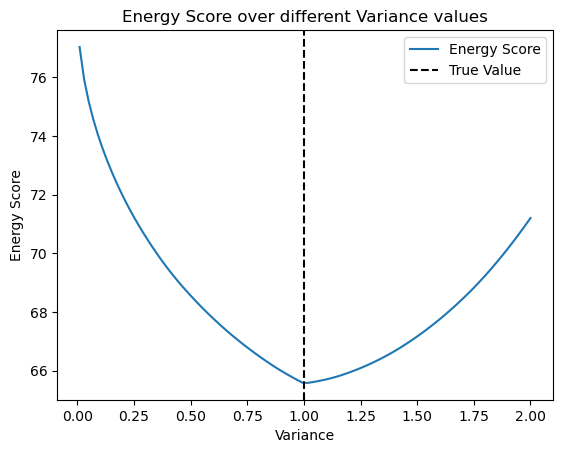

In [5]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



class SpatialGLMM:
    def __init__(self, grid_size, design_X):
        self.grid_size = grid_size
        self.num_locations = grid_size ** 2
        self.num_regression_covariates = 3
        self.design_X = design_X
    
    def linear_predictor(self, beta):
        return torch.matmul(self.design_X, beta)
    
    def generate_covariance_matrix(self, gp_variance, gp_length_scale):  
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = gp_variance * torch.exp(-0.5 * (pairwise_distances / gp_length_scale) ** 2) 
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)

        return covariance_matrix

    
    def sample_random_effects(self, covariance_matrix):
        mean = torch.zeros(self.num_locations)
        mvn = MultivariateNormal(mean, covariance_matrix=covariance_matrix)
        random_effects_samples = mvn.sample()
        return random_effects_samples
    
    def forward(self, beta, gp_variance, gp_length_scale):  
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(gp_variance, gp_length_scale)  
        random_effects_samples = self.sample_random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples
        return torch.exp(total_effects)



def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy


def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples))

#fixed 'true' values
choose_beta = torch.tensor((3., 1., -1.))
choose_gp_length_scale = 5.0
choose_grid_size = 5
choose_gp_variance = 1.0
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1)
SR_beta = 1.0
spatial_glmm = SpatialGLMM(grid_size=choose_grid_size,
                            design_X=choose_design_X)

num_real_samples = 500
num_fake_samples = 500

# Real samples from fixed parameters
torch.manual_seed(42)  
real_samples = [spatial_glmm.forward(choose_beta, gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_real_samples)]
    
SR_E = []
for i in tqdm(torch.linspace(0.01, 2, 100)):
    torch.manual_seed(42) 
    fake_samples = [spatial_glmm.forward(choose_beta, gp_variance=i, gp_length_scale=choose_gp_length_scale) for _ in range(num_fake_samples)]
    SR_E.append(SR_eval(SR_beta, real_samples, fake_samples))

plt.plot(torch.linspace(0.01, 2, 100), SR_E , label='Energy Score')

plt.axvline(x=1.0, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance')
plt.ylabel('Energy Score')
plt.title('Energy Score over different Variance values')


plt.show()


## Length Scale

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


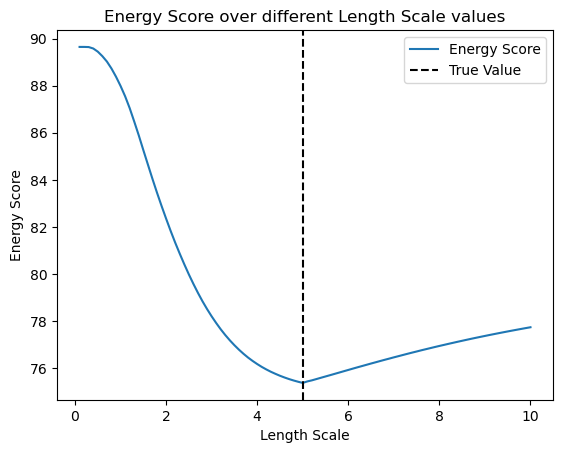

In [6]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



class SpatialGLMM:
    def __init__(self, grid_size, design_X):
        self.grid_size = grid_size
        self.num_locations = grid_size ** 2
        self.num_regression_covariates = 3
        self.design_X = design_X
    
    def linear_predictor(self, beta):
        return torch.matmul(self.design_X, beta)
    
    def generate_covariance_matrix(self, gp_variance, gp_length_scale): 
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = gp_variance * torch.exp(-0.5 * (pairwise_distances / gp_length_scale) ** 2)  
        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)

        return covariance_matrix

    
    def sample_random_effects(self, covariance_matrix):
        mean = torch.zeros(self.num_locations)
        mvn = MultivariateNormal(mean, covariance_matrix=covariance_matrix)
        random_effects_samples = mvn.sample()
        return random_effects_samples
    
    def forward(self, beta, gp_variance, gp_length_scale): 
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(gp_variance, gp_length_scale) 
        random_effects_samples = self.sample_random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples
        return torch.exp(total_effects)



def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy


def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples))

#fixed 'true' values
choose_beta = torch.tensor((3., 1., -1.))
choose_gp_length_scale = 5.0
choose_grid_size = 5
choose_gp_variance = 1.0
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1)
SR_beta = 1.0
spatial_glmm = SpatialGLMM(grid_size=choose_grid_size,
                            design_X=choose_design_X)

num_real_samples = 500
num_fake_samples = 500

# Real samples from fixed parameters
torch.manual_seed(42) 
real_samples = [spatial_glmm.forward(choose_beta, gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_real_samples)]
    
SR_E = []
for i in tqdm(torch.linspace(0.1, 10, 100)):
    torch.manual_seed(42) 
    fake_samples = [spatial_glmm.forward(choose_beta, gp_variance=choose_gp_variance, gp_length_scale=i) for _ in range(num_fake_samples)]
    SR_E.append(SR_eval(SR_beta, real_samples, fake_samples))

plt.plot(torch.linspace(0.1, 10, 100), SR_E , label='Energy Score')

plt.axvline(x=5.0, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Length Scale')
plt.ylabel('Energy Score')
plt.title('Energy Score over different Length Scale values')


plt.show()


## Beta 0

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


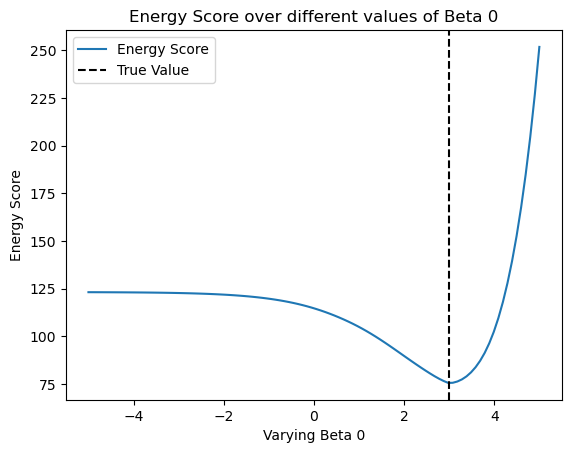

In [7]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class SpatialGLMM:
    def __init__(self, grid_size, design_X):
        self.grid_size = grid_size
        self.num_locations = grid_size ** 2
        self.num_regression_covariates = 3
        self.design_X = design_X
    
    def linear_predictor(self, beta):
        beta_tensor = torch.tensor(beta, dtype=torch.float) 
        return torch.matmul(self.design_X, beta_tensor)

    
    def generate_covariance_matrix(self, gp_variance, gp_length_scale):  
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = gp_variance * torch.exp(-0.5 * (pairwise_distances / gp_length_scale) ** 2)  

        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)
        
        return covariance_matrix
    
    def sample_random_effects(self, covariance_matrix):
        mean = torch.zeros(self.num_locations)
        mvn = MultivariateNormal(mean, covariance_matrix=covariance_matrix)
        random_effects_samples = mvn.sample()
        return random_effects_samples
    
    def forward(self, beta, gp_variance, gp_length_scale):  
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(gp_variance, gp_length_scale)  
        random_effects_samples = self.sample_random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples
        return torch.exp(total_effects)
 

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy


def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples))

#fixed 'true' values
choose_beta = torch.tensor((3., 1., -1.))
choose_gp_length_scale = 5.0
choose_gp_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1)
SR_beta = 1.0
spatial_glmm = SpatialGLMM(grid_size=choose_grid_size, design_X=choose_design_X)

num_real_samples = 500
num_fake_samples = 500

# Real samples from fixed parameters
torch.manual_seed(42)
real_samples = [spatial_glmm.forward((choose_beta[0], choose_beta[1], choose_beta[2]), gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_real_samples)]

SR_E = []
for i in tqdm(torch.linspace(-5, 5, 100)):  # Varying beta 0 in the range (-5, 5)
    torch.manual_seed(42)  
    fake_samples = [spatial_glmm.forward((i, choose_beta[1], choose_beta[2]), gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_fake_samples)]
    SR_E.append(SR_eval(SR_beta, real_samples, fake_samples))

plt.plot(torch.linspace(-5, 5, 100), SR_E , label='Energy Score') 

plt.axvline(x=3.0, color='black', linestyle='--', label='True Value')
plt.legend()

plt.xlabel('Varying Beta 0')
plt.ylabel('Energy Score')
plt.title('Energy Score over different values of Beta 0')

plt.show()


## Beta 1

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


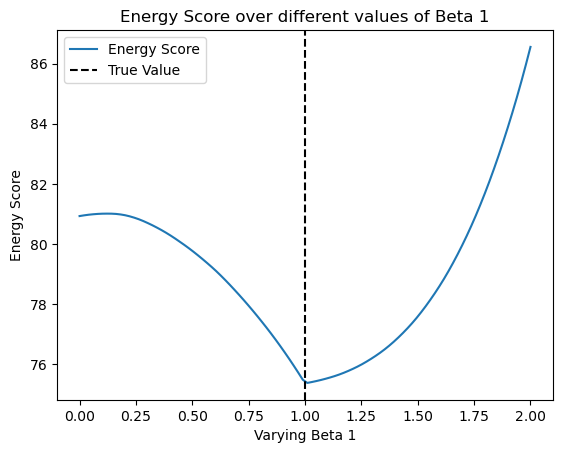

In [8]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class SpatialGLMM:
    def __init__(self, grid_size, design_X):
        self.grid_size = grid_size
        self.num_locations = grid_size ** 2
        self.num_regression_covariates = 3
        self.design_X = design_X
    
    def linear_predictor(self, beta):
        beta_tensor = torch.tensor(beta, dtype=torch.float) 
        return torch.matmul(self.design_X, beta_tensor)

    
    def generate_covariance_matrix(self, gp_variance, gp_length_scale):  
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = gp_variance * torch.exp(-0.5 * (pairwise_distances / gp_length_scale) ** 2)  

        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)
        
        return covariance_matrix
    
    def sample_random_effects(self, covariance_matrix):
        mean = torch.zeros(self.num_locations)
        mvn = MultivariateNormal(mean, covariance_matrix=covariance_matrix)
        random_effects_samples = mvn.sample()
        return random_effects_samples
    
    def forward(self, beta, gp_variance, gp_length_scale):  
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(gp_variance, gp_length_scale)  
        random_effects_samples = self.sample_random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples
        return torch.exp(total_effects)
 

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy


def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples))

#fixed 'true' values
choose_beta = torch.tensor((3., 1., -1.))
choose_gp_length_scale = 5.0
choose_gp_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1)
SR_beta = 1.0
spatial_glmm = SpatialGLMM(grid_size=choose_grid_size, design_X=choose_design_X)

num_real_samples = 500
num_fake_samples = 500

# Real samples from fixed parameters
torch.manual_seed(42)
real_samples = [spatial_glmm.forward((choose_beta[0], choose_beta[1], choose_beta[2]), gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_real_samples)]

SR_E = []
for i in tqdm(torch.linspace(0, 2, 100)):  # Varying beta 1 in the range (0, 2)
    torch.manual_seed(42)  
    fake_samples = [spatial_glmm.forward((choose_beta[0], i, choose_beta[2]), gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_fake_samples)]
    SR_E.append(SR_eval(SR_beta, real_samples, fake_samples))

plt.plot(torch.linspace(0, 2, 100), SR_E , label='Energy Score') 

plt.axvline(x=1.0, color='black', linestyle='--', label='True Value')
plt.legend()

plt.xlabel('Varying Beta 1')
plt.ylabel('Energy Score')
plt.title('Energy Score over different values of Beta 1')

plt.show()


## Beta 2

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


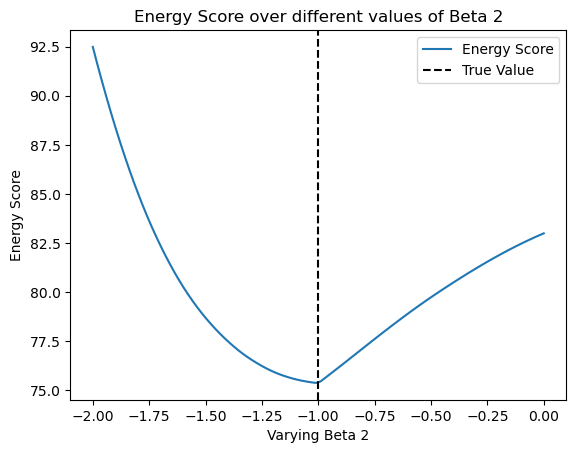

In [13]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class SpatialGLMM:
    def __init__(self, grid_size, design_X):
        self.grid_size = grid_size
        self.num_locations = grid_size ** 2
        self.num_regression_covariates = 3
        self.design_X = design_X
    
    def linear_predictor(self, beta):
        beta_tensor = torch.tensor(beta, dtype=torch.float)  
        return torch.matmul(self.design_X, beta_tensor)

    
    def generate_covariance_matrix(self, gp_variance, gp_length_scale):  
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = gp_variance * torch.exp(-0.5 * (pairwise_distances / gp_length_scale) ** 2)  

        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)
        
        return covariance_matrix
    
    def sample_random_effects(self, covariance_matrix):
        mean = torch.zeros(self.num_locations)
        mvn = MultivariateNormal(mean, covariance_matrix=covariance_matrix)
        random_effects_samples = mvn.sample()
        return random_effects_samples
    
    def forward(self, beta, gp_variance, gp_length_scale):  
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(gp_variance, gp_length_scale)  
        random_effects_samples = self.sample_random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples
        return torch.exp(total_effects)
 

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy


def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples))

#fixed 'true' values
choose_beta = torch.tensor((3., 1., -1.))
choose_gp_length_scale = 5.0
choose_gp_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1)
SR_beta = 1.0
spatial_glmm = SpatialGLMM(grid_size=choose_grid_size, design_X=choose_design_X)

num_real_samples = 500
num_fake_samples = 500

# Real samples from fixed parameters
torch.manual_seed(42)
real_samples = [spatial_glmm.forward((choose_beta[0], choose_beta[1], choose_beta[2]), gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_real_samples)]

SR_E = []
for i in tqdm(torch.linspace(-2, 0, 100)):  # Varying beta 2 in the range (-2, 0)
    torch.manual_seed(42)  
    fake_samples = [spatial_glmm.forward((choose_beta[0], choose_beta[1], i), gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_fake_samples)]
    SR_E.append(SR_eval(SR_beta, real_samples, fake_samples))

plt.plot(torch.linspace(-2, 0, 100), SR_E , label='Energy Score')  # Varying beta from -3 to 3

plt.axvline(x=-1.0, color='black', linestyle='--', label='True Value')
plt.legend()

plt.xlabel('Varying Beta 2')
plt.ylabel('Energy Score')
plt.title('Energy Score over different values of Beta 2')

plt.show()


# 5d Grid Search

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class SpatialGLMM:
    def __init__(self, grid_size, design_X):
        self.grid_size = grid_size
        self.num_locations = grid_size ** 2
        self.num_regression_covariates = 3
        self.design_X = design_X
    
    def linear_predictor(self, beta):
        beta_tensor = torch.tensor(beta, dtype=torch.float)
        return torch.matmul(self.design_X, beta_tensor)

    
    def generate_covariance_matrix(self, gp_variance, gp_length_scale):  
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = gp_variance * torch.exp(-0.5 * (pairwise_distances / gp_length_scale) ** 2)  

        # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)
        
        return covariance_matrix
    
    def sample_random_effects(self, covariance_matrix):
        mean = torch.zeros(self.num_locations)
        mvn = MultivariateNormal(mean, covariance_matrix=covariance_matrix)
        random_effects_samples = mvn.sample()
        return random_effects_samples
    
    def forward(self, beta, gp_variance, gp_length_scale):  
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(gp_variance, gp_length_scale)  
        random_effects_samples = self.sample_random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples
        return torch.exp(total_effects)
 

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy


def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples))

#fixed 'true' values
choose_beta = torch.tensor((3., 1., -1.))
choose_gp_length_scale = 5.0
choose_gp_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1)
SR_beta = 1.0
spatial_glmm = SpatialGLMM(grid_size=choose_grid_size, design_X=choose_design_X)

num_real_samples = 500
num_fake_samples = 500

# Real samples from fixed parameters
torch.manual_seed(42)
real_samples = [spatial_glmm.forward(choose_beta, gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_real_samples)]



# Grid search over variance and beta0
beta0_values = torch.linspace(2, 4, 5)
beta1_values = torch.linspace(0, 2, 5)
beta2_values = torch.linspace(-2, 0, 5)
variances = torch.linspace(0.5, 2.5, 5)
length_scales = torch.linspace(4, 6, 5)


SR_E = torch.zeros(len(beta0_values), len(beta1_values), len(beta2_values), len(variances), len(length_scales))

for i, beta0 in enumerate(beta0_values):
    for j, beta1 in enumerate(beta1_values):
        for k, beta2 in enumerate(beta2_values):
            for l, variance in enumerate(variances):
                for m, length_scale in enumerate(length_scales):
                    torch.manual_seed(42)
                    fake_samples = [spatial_glmm.forward((beta0, beta1, beta2), gp_variance=variance, gp_length_scale=length_scale) for _ in range(num_fake_samples)]  # Pass individual beta values
                    SR_E[i, j, k, l, m] = SR_eval(SR_beta, real_samples, fake_samples)

SR_E_flat = SR_E.view(-1)

# Get indices of the 10 lowest energy scores
lowest_indices = torch.argsort(SR_E_flat)[:10]

# Print the 10 lowest energy scores and their parameters
for index in lowest_indices:
    indices = np.unravel_index(index.item(), SR_E.shape)
    
    # Extract parameters
    beta0 = beta0_values[indices[0]].item()
    beta1 = beta1_values[indices[1]].item()
    beta2 = beta2_values[indices[2]].item()
    variance = variances[indices[3]].item()
    length_scale = length_scales[indices[4]].item()
    
    # Print parameters and the corresponding energy score
    print(f"Beta0: {beta0:.2f}, Beta1: {beta1:.2f}, Beta2: {beta2:.2f}, Variance: {variance:.2f}, Length Scale: {length_scale:.2f}, Energy Score: {SR_E_flat[index]:.2f}")


# 5d optimisation (Nedler-Mead)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import numpy as np
from scipy.optimize import minimize

class SpatialGLMM:
    def __init__(self, grid_size, design_X):
        self.grid_size = grid_size
        self.num_locations = grid_size ** 2
        self.num_regression_covariates = 3
        self.design_X = design_X
    
    def linear_predictor(self, beta):
        beta_tensor = torch.tensor(beta, dtype=torch.float)  
        return torch.matmul(self.design_X, beta_tensor)

    
    def generate_covariance_matrix(self, gp_variance, gp_length_scale):  
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = gp_variance * torch.exp(-0.5 * (pairwise_distances / gp_length_scale) ** 2)  

        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)
        
        return covariance_matrix
    
    def sample_random_effects(self, covariance_matrix):
        mean = torch.zeros(self.num_locations)
        mvn = MultivariateNormal(mean, covariance_matrix=covariance_matrix)
        random_effects_samples = mvn.sample()
        return random_effects_samples
    
    def forward(self, beta, gp_variance, gp_length_scale):  
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(gp_variance, gp_length_scale)  
        random_effects_samples = self.sample_random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples
        return torch.exp(total_effects)

def Energy_Score(energy_beta, observations_y, simulations_Y):
    m = len(simulations_Y)
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
             simulations_Y.unsqueeze(0)).float(),
            dim=2, keepdim=True).reshape(-1, 1),
        energy_beta)
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        energy_beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1, 1), fake_samples[i].view(-1, 1))
    return out / (len(real_samples) + len(fake_samples))

choose_beta = torch.tensor((3., 1., -1.))
choose_gp_length_scale = 5.0
choose_gp_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1)
SR_beta = 1.0
spatial_glmm = SpatialGLMM(grid_size=choose_grid_size, design_X=choose_design_X)

num_real_samples = 500
num_fake_samples = 500

torch.manual_seed(42)
real_samples = [spatial_glmm.forward(choose_beta, gp_variance=choose_gp_variance, gp_length_scale=choose_gp_length_scale) for _ in range(num_real_samples)]



def objective_function(params):
    beta0, beta1, beta2, variance, length_scale = params
    torch.manual_seed(42)
    fake_samples = [spatial_glmm.forward((beta0, beta1, beta2), gp_variance=variance, gp_length_scale=length_scale) for _ in range(num_fake_samples)]
    return SR_eval(SR_beta, real_samples, fake_samples).item()

# Define bounds for parameters
bounds = ((None, None), (None, None), (None, None), (1e-6, None), (1e-6, None)) #gp hyperparameters but be strictly positive
#generate random initial guesses (again positive for GP hyperparameters)
initial_guess = [np.random.normal(loc=0, scale=10), np.random.normal(loc=0, scale=10), np.random.normal(loc=0, scale=10), np.abs(np.random.normal(loc=0, scale=10))+1e-6, np.abs(np.random.normal(loc=0, scale=10))+1e-6]

# Nelder-Mead optimisation with bounds
result_nm = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
print("Nelder-Mead Optimization Result:")
print(result_nm)
